## Librerías:

In [31]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Visualización y métricas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from SupportFunc.Loader import MultiLabelImageDataset
from SupportFunc.AdaptiveAttention import AdaptiveAttention, AdaptiveTransformerEncoderLayer
from SupportFunc.Visualization import plot_confusion_matrix, plot_train_val_curve

## Parámetros y funciones:

In [32]:
# En el modelo AdaptiveAttentionClassifierWithCLIP
class AdaptiveAttentionClassifierWithCLIP(nn.Module):
    def __init__(self, clip_model, num_classes, seq_len=1):
        super(AdaptiveAttentionClassifierWithCLIP, self).__init__()
        self.clip_model = clip_model
        self.seq_len = seq_len
        self.image_embed = nn.Linear(512, 512)  # Embedding de CLIP al transformador
        self.transformer_encoder = nn.ModuleList([
            AdaptiveTransformerEncoderLayer(d_model=512, nhead=8) for _ in range(6)
        ])
        self.mlp = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, image_features):
        # Ajustar dimensiones (expandir artificialmente para seq_len)
        image_embeddings = image_features.unsqueeze(1).repeat(1, self.seq_len, 1)  # [batch_size, seq_len, 512]

        # Pasar por el Transformer
        for layer in self.transformer_encoder:
            image_embeddings = layer(image_embeddings)

        # Clasificación final
        output = self.mlp(image_embeddings[:, 0, :])  # Usar solo el primer token para la clasificación
        return output


In [33]:
# Obtener el directorio actual
current_directory = os.getcwd()
data_directory = os.path.join(current_directory[:-3], 'data')
images_directory = os.path.join(data_directory, 'images')

num_epochs = 10
batch_size = 32
lr = 0.001 
image_feature_dim = 2048

# Crear subset basado en los nombres de archivos en la carpeta de imágenes
subset = [os.path.splitext(filename)[0] for filename in os.listdir(images_directory)]
print(len(subset))

# Transformaciones para las imágenes
transform_clip = transforms.Compose([ transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     ])

2451


## Carga de datos:

### Selección de subset para pruebas:

In [ ]:
# Leer y filtrar datos
train_1 = pd.read_csv(f'{data_directory}/train_data.csv')
test_1 = pd.read_csv(f'{data_directory}/test_data.csv')

train_1 = train_1[train_1['ID'].isin(subset[:500])]
test_1 = test_1[test_1['ID'].isin(subset[:500])]

# Guardar los archivos filtrados
train_1.to_csv(f'{data_directory}/train_data_2.csv', encoding='utf-8', index=False)
test_1.to_csv(f'{data_directory}/test_data_2.csv', encoding='utf-8', index=False)

# Crear datasets y DataLoaders
train_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/train_data_2.csv", img_dir=f"{images_directory}/", transform=transform_clip)
test_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/test_data_2.csv", img_dir=f"{images_directory}/", transform=transform_clip)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Instanciar modelo:

In [35]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo CLIP
clip_model_name = "openai/clip-vit-base-patch32"  # Cambia el modelo si usas otro.
clip_model = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

# Asegúrate de mover el modelo CLIP al dispositivo adecuado (GPU o CPU)
clip_model = clip_model.to(device)

# Descongelar las capas para fine-tuning
for param in clip_model.parameters():
    param.requires_grad = True

# Crear modelo con atención adaptativa
model = AdaptiveAttentionClassifierWithCLIP(clip_model=clip_model, num_classes=train_dataset[0][1].size(0))
model = model.to(device)

# Configuración del optimizador y función de pérdida
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

## Entrenamiento:

In [36]:
from sklearn.metrics import accuracy_score, f1_score

# Entrenamiento
train_losses = list()
val_losses = list()
train_accuracies = list()
val_accuracies = list()
train_f1_scores = list()
val_f1_scores = list()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for images, labels in train_loader:
        # Mover imágenes y etiquetas al dispositivo
        images, labels = images.to(device), labels.to(device)

        # Convertir imágenes a formato adecuado para CLIP
        images = [transforms.ToPILImage()(img) for img in images]  # Convertir tensores a imágenes PIL
        image_inputs = clip_processor(images=images, return_tensors="pt", padding=True)
        image_inputs = {key: val.to(device) for key, val in image_inputs.items()}

        # Obtener embeddings de imagen desde CLIP
        with torch.no_grad():
            image_features = clip_model.get_image_features(**image_inputs)

        # Pasar las características al modelo con atención adaptativa
        outputs = model(image_features)

        # Calcular la pérdida
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calcular predicciones para métricas
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()  # Umbral de 0.5 para predicciones binarias
        all_train_labels.append(labels.cpu().numpy())
        all_train_preds.append(preds.cpu().numpy())

    # Calcular métricas para entrenamiento
    all_train_labels = np.vstack(all_train_labels)
    all_train_preds = np.vstack(all_train_preds)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average="macro", zero_division=1)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)

    # Validación
    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Mover imágenes y etiquetas al dispositivo
            images, labels = images.to(device), labels.to(device)
            images = [transforms.ToPILImage()(img) for img in images]
            image_inputs = clip_processor(images=images, return_tensors="pt", padding=True)
            image_inputs = {key: val.to(device) for key, val in image_inputs.items()}
            image_features = clip_model.get_image_features(**image_inputs)

            outputs = model(image_features)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calcular predicciones para métricas
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()  # Umbral de 0.5 para predicciones binarias
            all_val_labels.append(labels.cpu().numpy())
            all_val_preds.append(preds.cpu().numpy())

    # Calcular métricas para validación
    all_val_labels = np.vstack(all_val_labels)
    all_val_preds = np.vstack(all_val_preds)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds, average="macro", zero_division=1)

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    # Imprimir métricas
    print(
        f"Epoch {epoch+1}/{num_epochs}, "
        f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
        f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}, "
        f"Train F1: {train_f1_scores[-1]:.4f}, Val F1: {val_f1_scores[-1]:.4f}"
    )


Epoch 1/10, Train Loss: 0.2347, Val Loss: 0.2114, Train Acc: 0.0006, Val Acc: 0.0000, Train F1: 0.0174, Val F1: 0.0000
Epoch 2/10, Train Loss: 0.2129, Val Loss: 0.2150, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0000, Val F1: 0.0000
Epoch 3/10, Train Loss: 0.2146, Val Loss: 0.2101, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0000, Val F1: 0.0000
Epoch 4/10, Train Loss: 0.2134, Val Loss: 0.2124, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0000, Val F1: 0.0000
Epoch 5/10, Train Loss: 0.2131, Val Loss: 0.2109, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0000, Val F1: 0.0000
Epoch 6/10, Train Loss: 0.2139, Val Loss: 0.2103, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0000, Val F1: 0.0000
Epoch 7/10, Train Loss: 0.2124, Val Loss: 0.2100, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0000, Val F1: 0.0000
Epoch 8/10, Train Loss: 0.2123, Val Loss: 0.2100, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0000, Val F1: 0.0000
Epoch 9/10, Train Loss: 0.2121, Val Loss: 0.2116

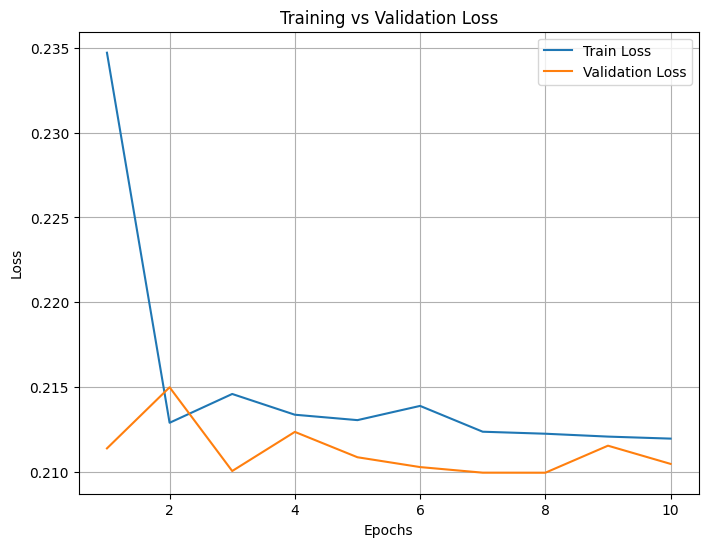

In [37]:
plot_train_val_curve(num_epochs, train_losses, val_losses)

## Inferencia y métricas:

Test Accuracy: 0.0000, Test F1 Score: 0.0000


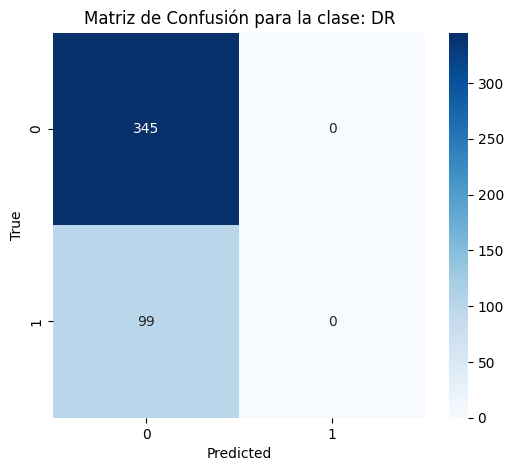

In [38]:
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix

# Colocar el modelo en modo evaluación
model.eval()

# Listas para almacenar etiquetas reales y predicciones
all_labels = []
all_preds = []

# Realizar inferencia
with torch.no_grad():  # No calculamos gradientes
    for images, labels in test_loader:
        # Mover imágenes y etiquetas al dispositivo
        labels = labels.to(device)
        images = [transforms.ToPILImage()(img) for img in images]  # Convertir tensores a imágenes PIL
        image_inputs = clip_processor(images=images, return_tensors="pt", padding=True)
        image_inputs = {key: val.to(device) for key, val in image_inputs.items()}

        # Obtener embeddings de imagen desde CLIP
        image_features = clip_model.get_image_features(**image_inputs)

        # Pasar las características al modelo con atención adaptativa
        outputs = model(image_features)

        # Aplicar sigmoid para obtener probabilidades
        probs = torch.sigmoid(outputs)

        # Convertir probabilidades en predicciones binarias (umbral = 0.5)
        preds = (probs > 0.5).int()

        # Guardar etiquetas reales y predicciones
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

# Convertir listas a arreglos
all_labels = np.vstack(all_labels)  # Etiquetas reales
all_preds = np.vstack(all_preds)    # Predicciones

# Calcular métricas
test_accuracy = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=1)

# Calcular matriz de confusión para cada etiqueta
confusion_matrices = multilabel_confusion_matrix(all_labels, all_preds)

# Imprimir resultados
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

# Ejemplo: visualizar la matriz de confusión para la primera etiqueta
class_name = test_dataset.data.columns[1]  # Obtén el nombre de la primera clase
plot_confusion_matrix(confusion_matrices[0], class_name)


In [39]:
print(f'test_accuracy: {test_accuracy}, test_f1: {test_f1}')

test_accuracy: 0.0, test_f1: 0.0


In [41]:
# Imprimir métricas de clasificación
print("Reporte de clasificación (por etiqueta):")
print(classification_report(all_labels, all_preds, target_names=test_dataset.data.columns[1:], zero_division=0))

Reporte de clasificación (por etiqueta):
              precision    recall  f1-score   support

          DR       0.00      0.00      0.00        99
      NORMAL       0.00      0.00      0.00        98
          MH       0.00      0.00      0.00        34
         ODC       0.00      0.00      0.00        52
        TSLN       0.00      0.00      0.00        31
        ARMD       0.00      0.00      0.00        32
          DN       0.00      0.00      0.00        32
         MYA       0.00      0.00      0.00        18
        BRVO       0.00      0.00      0.00        16
         ODP       0.00      0.00      0.00        12
        CRVO       0.00      0.00      0.00        11
         CNV       0.00      0.00      0.00        12
          RS       0.00      0.00      0.00        11
         ODE       0.00      0.00      0.00        11
          LS       0.00      0.00      0.00         9
         CSR       0.00      0.00      0.00         7
         HTR       0.00      0.00      0